In [249]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
from nba_api.stats.endpoints import leaguegamefinder
from sklearn.ensemble import GradientBoostingClassifier

## Loading Data and Plotting 3P stats over time

In [213]:
data = pd.read_excel('book2.xlsx', index_col=0)  
data = data.reset_index()
data = data.rename(columns={"index": "team"})

In [214]:
data.head()


,team,3PM,3PA,3P%,3P% share in Total Points,Year
0,Atlanta Hawks,8,22.4,36,25.32,1996-97
1,Boston Celtics,5.7,16.2,35.1,16.99,1996-97
2,Brooklyn Nets,5.9,16.7,35.3,18.21,1996-97
3,Chicago Bulls,6.4,17.1,37.3,18.63,1996-97
4,Cleveland Cavaliers,5.9,15.7,37.6,20.23,1996-97


In [215]:
def year_clean(year):
    return year[0:4]

data['year'] = data.apply(lambda row : year_clean(row['Year']), axis = 1)
data = data.drop(columns = ['Year'])

In [216]:
data = data.replace(r'^\s*$', 0, regex=True)

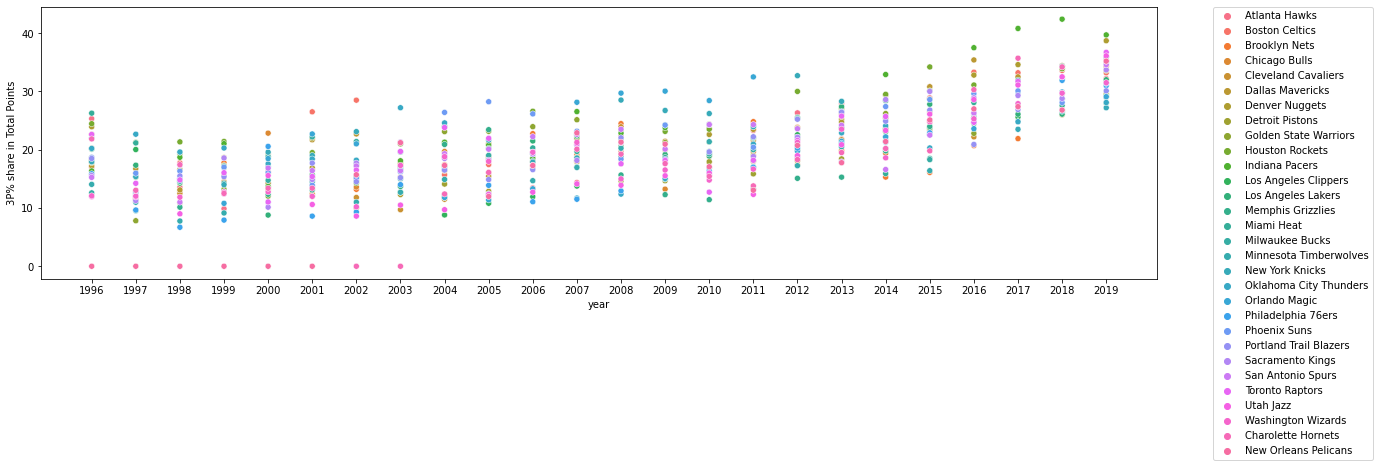

In [217]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.scatterplot(data=data, x="year", y="3P% share in Total Points",hue = 'team',ax =ax)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()
#0 values because NO Pelicans didn't exist

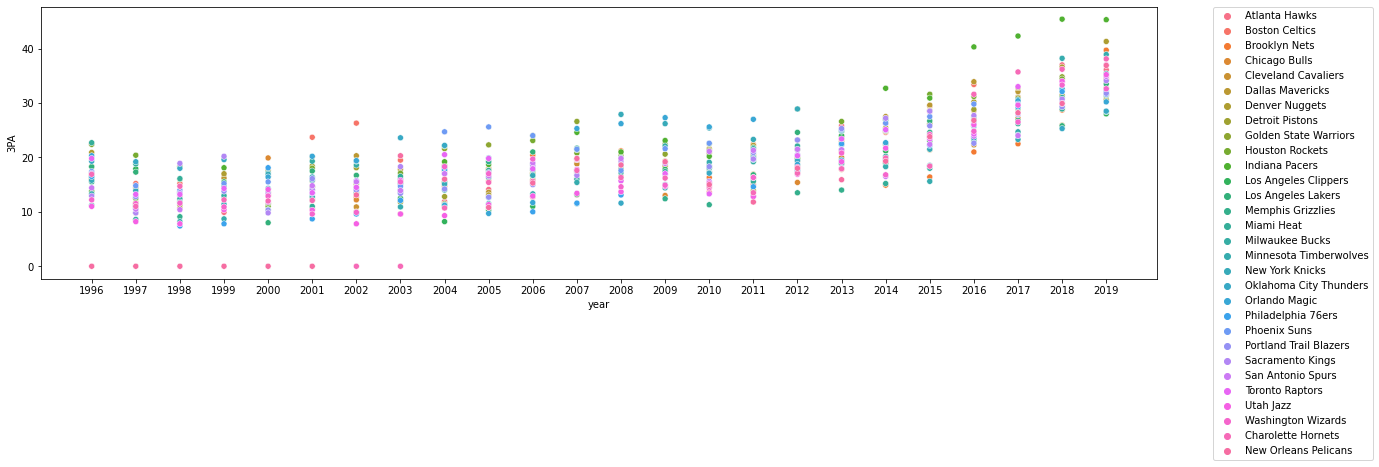

In [218]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.scatterplot(data=data, x="year", y="3PA",hue = 'team',ax =ax)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

In [219]:
warriors = data[data['team'] == 'Golden State Warriors']

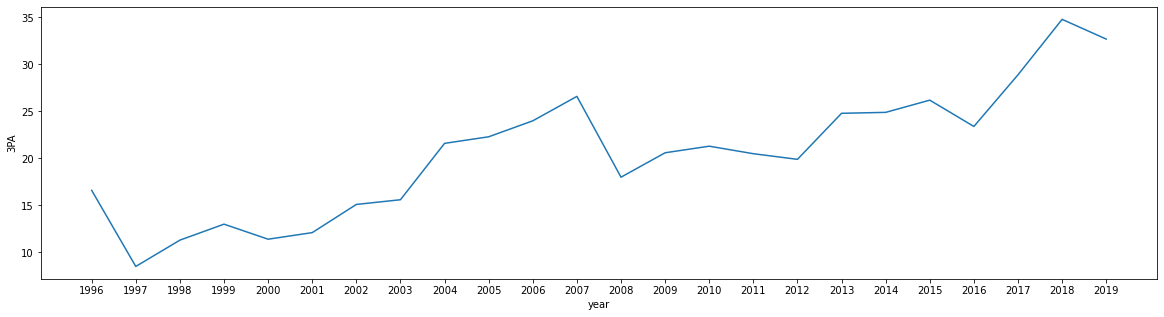

In [220]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.lineplot(data=warriors, x="year", y="3PA",ax =ax)
plt.show()

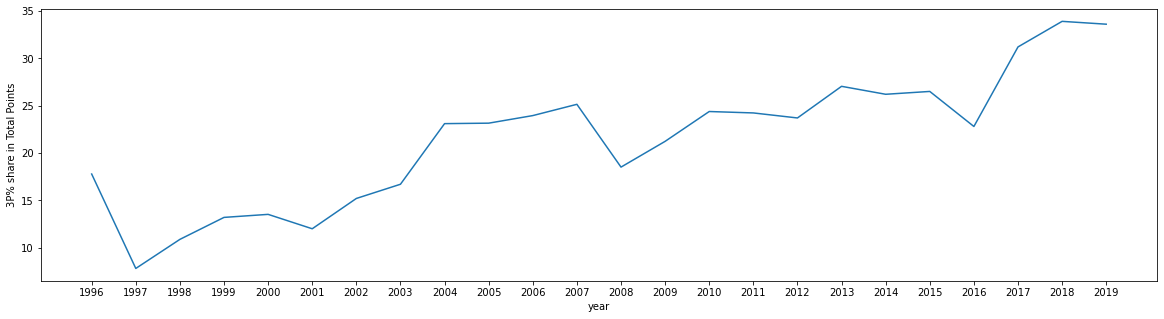

In [221]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.lineplot(data=warriors, x="year", y="3P% share in Total Points",ax =ax)
plt.show()

In [228]:
team_ids = [1610612752, 1610612739, 1610612741, 1610612737, 1610612764,
            1610612747, 1610612745, 1610612758, 1610612756, 1610612755,
            1610612760, 1610612740, 1610612743, 1610612750, 1610612763,
            1610612749, 1610612766, 1610612761, 1610612765, 1610612751,
            1610612738, 1610612742, 1610612754, 1610612753, 1610612748,
            1610612744, 1610612759, 1610612762, 1610612757, 1610612746]
nba_teams = ['Cleveland Cavaliers','Boston Celtics','Golden State Warriors','Houston Rockets','Utah Jazz'
             ,'Philadelphia 76ers','Toronto Raptors','New Orleans Pelicans','Washington Wizards','Miami Heat'
            ,'Milwaukee Bucks','Indiana Pacers','Oklahoma City Thunder','San Antonio Spurs','Portland Trail Blazers',
             'Minnesota Timberwolves','Chicago Bulls','Dallas Mavericks','Sacramento Kings','Los Angeles Lakers'
            ,'Orlando Magic','Denver Nuggets','LA Clippers','New York Knicks','Memphis Grizzlies','Detroit Pistons'
            ,'Charlotte Hornets','Atlanta Hawks','Phoenix Suns','Brooklyn Nets']

In [232]:
def pull_reg_season(start_date, end_date):
    reg = pd.DataFrame()
    for i in team_ids:
        games_base = leaguegamefinder.LeagueGameFinder(team_id_nullable = i)
        games_xxxx = games_base.get_data_frames()[0]
        games_xxxx = games_xxxx[games_xxxx.TEAM_NAME.isin(nba_teams)]
        regular_xxxx = games_xxxx[(games_xxxx.GAME_DATE > start_date) & (games_xxxx.GAME_DATE < end_date)]
        reg = reg.append(regular_xxxx)
        time.sleep(5)
    reg = reg.sort_values('GAME_ID')
    return reg

## Comparing Ability of 3P stats to predict winning, between 96-97 and 19-20 

In [238]:
ninetysix = pull_reg_season('1996-10-10','1997-04-21')
twentynineteen = pull_reg_season('2019-10-10','2020-04-01')

In [240]:
X96 = ninetysix[['FG3M', 'FG3A', 'FG3_PCT']]
X19 = twentynineteen[['FG3M', 'FG3A', 'FG3_PCT']]


In [241]:
def get_result(WL):
    if(WL == 'W'):
        return 1
    else:
        return 0
    
ninetysix['result'] = ninetysix.apply(lambda row : get_result(row['WL']), axis = 1)
twentynineteen['result'] = twentynineteen.apply(lambda row : get_result(row['WL']), axis = 1)

In [242]:
y96 = ninetysix['result']
y19 = twentynineteen['result']

In [247]:
X_train96 = X96.iloc[0:1500,:]
X_test96 = X96.iloc[1500:,:]
X_train19 = X19.iloc[0:1500,:]
X_test19 = X19.iloc[1500:,:]
y_train96 = y96[0:1500]
y_test96 = y96[1500:]
y_train19 = y19[0:1500]
y_test19 = y19[1500:]


In [250]:
model96 = GradientBoostingClassifier()
model19 = GradientBoostingClassifier()

In [252]:
model96.fit(X_train96,y_train96)
model19.fit(X_train19,y_train19)

GradientBoostingClassifier()

In [257]:
from sklearn.metrics import mean_squared_error

In [258]:
mse96 = mean_squared_error(y_test96,model96.predict(X_test96))
mse19 = mean_squared_error(y_test19,model19.predict(X_test19))

In [261]:
print('Mean Squared Error 1996-97: ' + str(mse96))
print('Mean Squared Error 2019-2020: ' + str(mse19))

Mean Squared Error 1996-97: 0.4017094017094017
Mean Squared Error 2019-2020: 0.35619047619047617


# As seen from the lower mse, three pointers have greater ability to predict outcome in the modern NBA than 25 years ago